# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install simple_colors

In [2]:
!pip install lightgbm

In [3]:
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from simple_colors import *

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data['RegistrationYear'].dtype == 'object'

False

/tmp/ipykernel_101/2395323322.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(data.columns):


  0%|          | 0/16 [00:00<?, ?it/s]

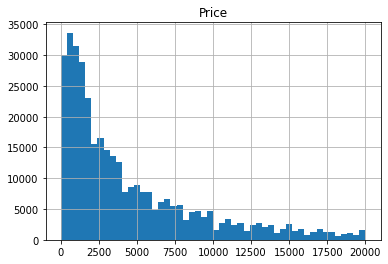

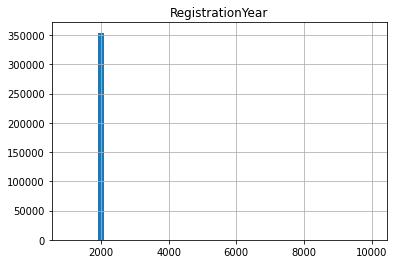

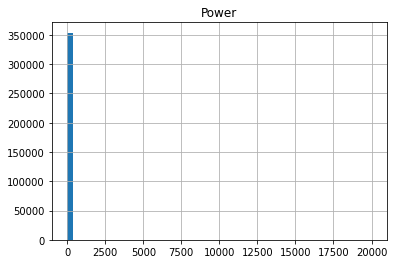

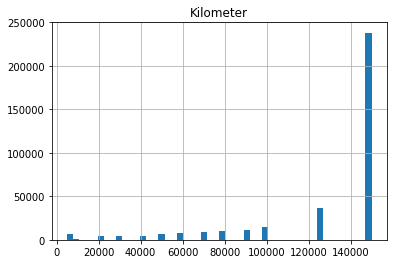

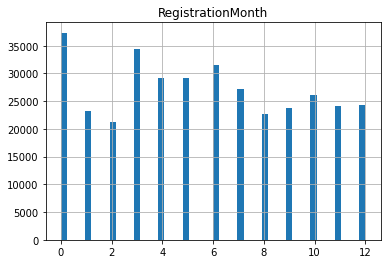

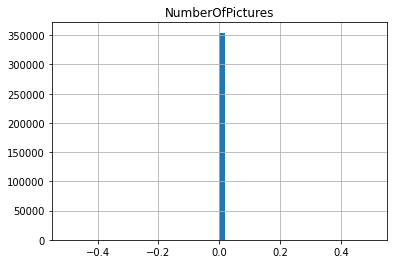

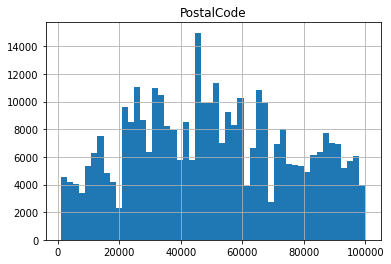

In [7]:
for col in tqdm_notebook(data.columns):
    if data[col].dtype != 'object':
        data[col].hist(bins=50)
        plt.title(col)
        plt.show()

Некоторые данные имеют явные выбросы, с которыми стоит бороться

In [8]:
data['NumberOfPictures'].unique()

array([0])

In [9]:
data.loc[~(data['RegistrationYear'].isin(list(range(1990, 2023)))), 'RegistrationYear'] = 2010
data.loc[~(data['Power'].isin(list(range(50, 1000)))), 'Power'] = 180
data.drop(['NumberOfPictures'], axis=1, inplace=True)

Признак "была ли машина в ремонте" может говорить о многом, поэтому лучше выбросим пропуски

In [10]:
data = data.loc[~(data['NotRepaired'].isna()), :]

In [11]:
for col in tqdm_notebook(data.columns):
    if data[col].dtype == 'object':
        print(red(col, 'bold'))
        print(data[col].value_counts().sort_values(ascending=False), '\n')

/tmp/ipykernel_101/2542299117.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(data.columns):


  0%|          | 0/15 [00:00<?, ?it/s]

DateCrawled
2016-03-24 14:49:47    6
2016-03-29 22:50:49    5
2016-03-22 14:50:05    5
2016-03-09 13:50:56    5
2016-03-08 15:50:29    5
                      ..
2016-03-09 17:49:50    1
2016-03-30 14:48:54    1
2016-03-31 18:52:31    1
2016-03-28 20:53:25    1
2016-03-14 22:37:02    1
Name: DateCrawled, Length: 228781, dtype: int64 

VehicleType
sedan          77617
small          64891
wagon          54967
bus            25197
convertible    17526
coupe          13393
suv            10569
other           2136
Name: VehicleType, dtype: int64 

Gearbox
manual    219847
auto       56323
Name: Gearbox, dtype: int64 

Model
golf                  22972
other                 20163
3er                   16141
polo                  10023
corsa                  9528
                      ...  
kalina                    6
samara                    5
serie_3                   3
rangerover                3
range_rover_evoque        2
Name: Model, Length: 249, dtype: int64 

FuelType
petrol      1

Заметим, что пропуски только в категориальных данных, поэтому просто заполним пропуски самыми частыми значениями

In [12]:
for col in tqdm_notebook(data.columns):
    if data[col].isna().sum() != 0:
        fill_value = data[col].value_counts().sort_values(ascending=False)[0]
        data[col] = data[col].fillna(fill_value)

/tmp/ipykernel_101/3617188587.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(data.columns):


  0%|          | 0/15 [00:00<?, ?it/s]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283215 entries, 1 to 354367
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        283215 non-null  object
 1   Price              283215 non-null  int64 
 2   VehicleType        283215 non-null  object
 3   RegistrationYear   283215 non-null  int64 
 4   Gearbox            283215 non-null  object
 5   Power              283215 non-null  int64 
 6   Model              283215 non-null  object
 7   Kilometer          283215 non-null  int64 
 8   RegistrationMonth  283215 non-null  int64 
 9   FuelType           283215 non-null  object
 10  Brand              283215 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        283215 non-null  object
 13  PostalCode         283215 non-null  int64 
 14  LastSeen           283215 non-null  object
dtypes: int64(6), object(9)
memory usage: 34.6+ MB


/tmp/ipykernel_101/2395323322.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(data.columns):


  0%|          | 0/15 [00:00<?, ?it/s]

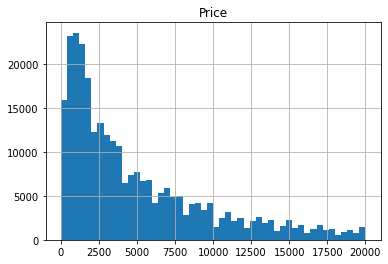

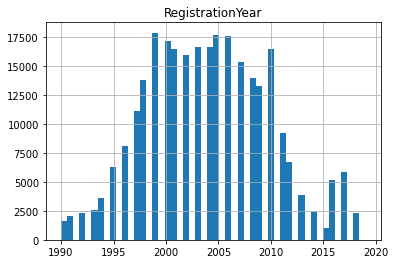

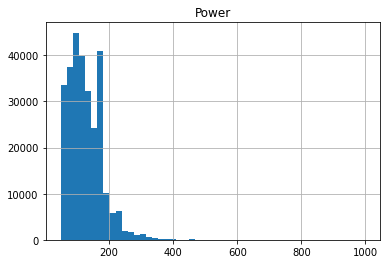

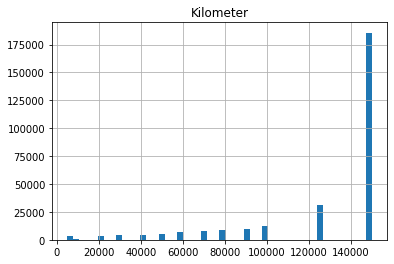

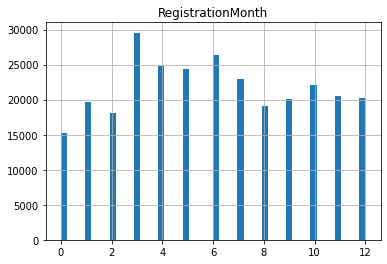

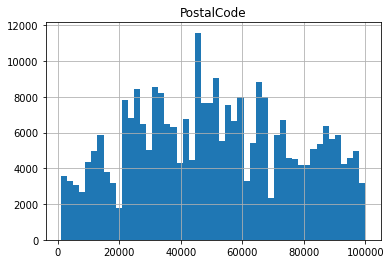

In [14]:
for col in tqdm_notebook(data.columns):
    if data[col].dtype != 'object':
        data[col].hist(bins=50)
        plt.title(col)
        plt.show()

In [15]:
data['LastSeen'] = pd.to_datetime(data['LastSeen'])
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])

In [16]:
data['LastSeen'].dt.year.value_counts()

2016    283215
Name: LastSeen, dtype: int64

In [17]:
data['DateCrawled'].dt.year.value_counts()

2016    283215
Name: DateCrawled, dtype: int64

In [18]:
data['DateCreated'].dt.year.value_counts()

2016    283193
2015        22
Name: DateCreated, dtype: int64

Бессмысленные признаки, так как имеют нулевую дисперсию. Просто дропнем их

In [19]:
data = data.drop(['DateCreated', 'DateCrawled', 'LastSeen'], axis=1)
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
1,18300,coupe,2011,manual,190,22972,125000,5,gasoline,audi,yes,66954
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,67112


In [20]:
for col in tqdm_notebook(data.columns):
    if data[col].dtype == 'object':
        data[col] = data[col].astype('category')

/tmp/ipykernel_101/267362933.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for col in tqdm_notebook(data.columns):


  0%|          | 0/12 [00:00<?, ?it/s]

## Обучение моделей

In [21]:
X = data.drop('Price', axis=1)
y = data['Price']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.4)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size=0.5)

In [22]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [23]:
%%time
cat1 = CatBoostRegressor(verbose=False, iterations=500, learning_rate=0.1)
cat1.fit(X_train, y_train, cat_features=cat_features)

CPU times: user 1min 23s, sys: 518 ms, total: 1min 23s
Wall time: 1min 24s


In [24]:
cat1_pred = cat1.predict(X_valid)
mean_squared_error(y_valid, cat1_pred) ** 0.5

1796.4304332416812

In [25]:
%%time
cat2 = CatBoostRegressor(verbose=False, iterations=1000, learning_rate=0.05)
cat2.fit(X_train, y_train, cat_features=cat_features)

CPU times: user 2min 48s, sys: 647 ms, total: 2min 49s
Wall time: 2min 50s


In [26]:
cat2_pred = cat2.predict(X_valid)
mean_squared_error(y_valid, cat2_pred) ** 0.5

1795.4075614752126

In [27]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169929 entries, 242139 to 195111
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   VehicleType        169929 non-null  category
 1   RegistrationYear   169929 non-null  int64   
 2   Gearbox            169929 non-null  category
 3   Power              169929 non-null  int64   
 4   Model              169929 non-null  category
 5   Kilometer          169929 non-null  int64   
 6   RegistrationMonth  169929 non-null  int64   
 7   FuelType           169929 non-null  category
 8   Brand              169929 non-null  category
 9   NotRepaired        169929 non-null  category
 10  PostalCode         169929 non-null  int64   
dtypes: category(6), int64(5)
memory usage: 8.9 MB


In [28]:
%%time
lgb1 = LGBMRegressor(learning_rate=0.05, device_type='cpu')
lgb1.fit(X_train, y_train, feature_name='auto', categorical_feature = 'auto')

CPU times: user 3min 46s, sys: 2.05 s, total: 3min 48s
Wall time: 3min 48s


LGBMRegressor(device_type='cpu', learning_rate=0.05)

In [29]:
lgb1_pred = lgb1.predict(X_valid)
mean_squared_error(y_valid, lgb1_pred) ** 0.5

1853.9447448595001

In [23]:
%%time
lgb2 = LGBMRegressor(learning_rate=0.2, device_type='cpu')
lgb2.fit(X_train, y_train, feature_name='auto', categorical_feature = 'auto')

CPU times: user 1min 53s, sys: 260 ms, total: 1min 53s
Wall time: 1min 53s


LGBMRegressor(device_type='cpu', learning_rate=0.2)

In [24]:
lgb2_pred = lgb2.predict(X_valid)
mean_squared_error(y_valid, lgb2_pred) ** 0.5

1743.8584991166006

In [25]:
X_train_linear = X_train.copy()
X_valid_linear = X_valid.copy()
X_test_linear = X_test.copy()
encoder = OrdinalEncoder()
encoder.fit(pd.concat([X_train[cat_features], X_valid[cat_features]]).astype('str'))
X_train_linear[cat_features] = encoder.transform(X_train[cat_features].astype('str'))
X_valid_linear[cat_features] = encoder.transform(X_valid[cat_features].astype('str'))
X_test_linear[cat_features] = encoder.transform(X_test[cat_features].astype('str'))

In [26]:
%%time
lin_reg1 = LinearRegression(normalize=True)
lin_reg1.fit(X_train_linear, y_train)

CPU times: user 56.3 ms, sys: 16 ms, total: 72.4 ms
Wall time: 50.3 ms


LinearRegression(normalize=True)

In [27]:
lin_reg1_pred = lin_reg1.predict(X_valid_linear)
mean_squared_error(y_valid, lin_reg1_pred) ** 0.5

3211.2760803416572

In [28]:
%%time
params = {'max_depth': range(10, 16, 2), 'min_samples_split': range(3, 11, 3)}
grid = GridSearchCV(DecisionTreeClassifier(), params, cv=3)
grid.fit(X_train_linear, y_train)

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"


CPU times: user 2min 33s, sys: 7.47 s, total: 2min 41s
Wall time: 2min 41s


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(10, 16, 2),
                         'min_samples_split': range(3, 11, 3)})

In [29]:
tree = grid.best_estimator_
tree_pred = tree.predict(X_valid_linear)
mean_squared_error(y_valid, tree_pred) ** 0.5

2573.243457836163

## Анализ моделей

LightGBM оказалась лучшей на валидационной выборке и по скорости и по каечтву. Поэтому на тестовой выборке проверять юуду именно эту модель, и оставлю ее. На более сложных моделях прошло переобучение. Самой быстрой моделью оказалось линейная регрессия, но ее качества недостаточно для данной задачи. Поэтому LightGBM является в данном случае лучшим решением

In [30]:
lgb2_pred_test = lgb2.predict(X_test)
mean_squared_error(y_test, lgb2_pred_test) ** 0.5

1759.123810324804

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей